# Classifying Endemic Weeds in Australia using a Neural Network

Method Used: Transfer Learning using Resnet-50 architecture (+2 dense layers) and tuning its weights. Sequential training on 4 stratified-split subsets and testing on one test subset. Basic data augmentation for more generalisation.

Accelerated on Kaggle using the P100 GPU and the uploaded dataset. The model achieves breakthrough accuracy of 99% on the test AND train set. Robust measures prevent overfitting: Early stopping and dropout.

These, along with LR reduction on plateaus aid the model to generalise and train accurately. The extremely high precision, recall, f1 score and area under the ROC curve show a robust and generalised ultra-efficient model.

The low log loss shows that the model is very confident in its prediction_ints.

## Implemented by Pratham Shah, 240905614, for the Cryptonite Research AI Taskphase

## Imports

In [11]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, auc, roc_curve, log_loss, accuracy_score, precision_score, f1_score, recall_score
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

In [12]:
!nvidia-smi

Wed Jun 18 07:28:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             33W /  250W |     513MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Customising Transfer Learning: The Model

Model structure:

- Resnet50, trained on imagenet but can be tuned further
- Global Average Pooling
- Dropout
- Dense softmax

Why this worked:
The ResNet detects very rich features pertaining to natural classes like leaves etc. Its weights already perform rich feature extraction. This makes reclassification on weeds very easy with small tuning.
Moreover, the residual skip connections do well to ensure the gradients and losses are stable and valid, allowing efficient training

In [ ]:
base_model = tf.keras.applications.ResNet50(
    include_top=False, #ignores the classification head (everything after globalaveragepooling2d)
    weights='imagenet', #pretrained on imagenet1000 - identifies rich features
    input_tensor=layers.Input(shape=(224, 224, 3)) #input shape
)
base_model.trainable = True #all the weights are modifiable

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), #forces feature maps into the average value of their pixels
    layers.Dropout(0.1),
    layers.Dense(9, activation='softmax') #[0,0,1,0,0,0,0,0,0] -> [0.2, 0.1, 0.8, 0.3, 0.1, ...]
])

model.compile(optimizer=tf.keras.optimizers.Adam(), #handles momentum, scaling and per-param LR
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │          18,441 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,606,153 (90.05 MB)

 Trainable params: 23,553,033 (89.85 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Model Callbacks: Early Stopping, Reduce LR on Plateau, Saving Best Weights

In [14]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True) #stop early if the val loss doesn't decrease beyond 7 epochs and restore the model to its best weights
# if val loss increases, its a sign of overfitting - the model's memorising the train data

reducelronplateau = tf.keras.callbacks.ReduceLROnPlateau( #if the performance isn't improving, the model reduces LR
    monitor='val_loss', 
    factor=0.5, #reduce by this factor. eg 0.5x will half the LR
    patience=3, #how many epochs long the performance stagnation will last before LR forced to reduce
    verbose=1,
    min_lr=1e-5  #minimum LR- prevents too much reduction
) #done to ensure that the model reaches its local minima instead of continually overshooting it

saver = tf.keras.callbacks.ModelCheckpoint("model_best.h5", save_best_only=True)

## Sequential Training

The same model is sequentially trained and validated on:
1. train_subset1, val_subset1,
2. train_subset2, val_subset2,
3. train_subset3, val_subset3,
4. train_subset4, val_subset4,
each for 10 epochs.

This approach works in this case because we have 9 overlapping classes common to all subsets.

In [ ]:
epochs = 10 #go 10x over the train set
image_size = (224, 224)
batch_size = 32
datagen = ImageDataGenerator(rescale=1/255, rotation_range=30) #normalises pixels from 0-1, gives random rotation till +- 30 deg

label_map = {
    0: "Chinee_Apple", 
    1: "Lantana", 
    2: "Parkinsonia",
    3: "Parthenium", 
    4: "Prickly_Acacia", 
    5: "Rubber_Vine",
    6: "Siam_Weed", 
    7: "Snake_Weed", 
    8: "Negative"
}

total_history = []


for subset in range(5):
    print("*" * 40)
    print(f"Training on subset {subset}:\n")

    trainer = pd.read_csv(f"/kaggle/input/deepweeds-final-please-god/labels/train_subset{subset}.csv")
    validator = pd.read_csv(f"/kaggle/input/deepweeds-final-please-god/labels/val_subset{subset}.csv")

    trainer["Filename"] = "/kaggle/input/deepweeds-final-please-god/images/" + trainer["Filename"] #appending full image path for easier loading
    validator["Filename"] = "/kaggle/input/deepweeds-final-please-god/images/" + validator["Filename"]
    
    # compute weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(trainer["Label"]), #not using the label map because not sure if all 9 classes are in
        y=trainer["Label"]
    )

     #{class_index: weight}
    class_weights = dict(enumerate(class_weights))

    train_gen = datagen.flow_from_dataframe(
        trainer,
        x_col="Filename",
        y_col="Label",
        target_size=image_size,
        batch_size=batch_size,
        class_mode="categorical"
    )

    val_gen = datagen.flow_from_dataframe(
        validator,
        x_col="Filename",
        y_col="Label",
        target_size=image_size,
        batch_size=batch_size,
        class_mode="categorical" #onehot
    )

    # train for this subset
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        class_weight = class_weights, #done to reduce the class imbalance - loss per item * (nsamples / nclasses * nsamples_c)
        callbacks=[early_stop, reducelronplateau, saver]
    )

    total_history.append(history)

****************************************
Training on subset 0:

Found 10501 validated image filenames belonging to 9 classes.
Found 3501 validated image filenames belonging to 9 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_360']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1750231751.993000      97 service.cc:148] XLA service 0x789468002fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750231751.993720      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750231756.606923      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/329 ━━━━━━━━━━━━━━━━━━━━ 6:37:57 73s/step - accuracy: 0.0625 - loss: 4.8459

I0000 00:00:1750231776.789818      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


329/329 ━━━━━━━━━━━━━━━━━━━━ 289s 658ms/step - accuracy: 0.5274 - loss: 2.6746 - val_accuracy: 0.5201 - val_loss: 2.2991 - learning_rate: 0.0010
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 156s 474ms/step - accuracy: 0.6585 - loss: 1.5137 - val_accuracy: 0.4344 - val_loss: 3.2354 - learning_rate: 0.0010
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 155s 470ms/step - accuracy: 0.7383 - loss: 1.1083 - val_accuracy: 0.5453 - val_loss: 2.3252 - learning_rate: 0.0010
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 155s 471ms/step - accuracy: 0.7794 - loss: 0.9235 - val_accuracy: 0.5316 - val_loss: 1.5391 - learning_rate: 0.0010
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 155s 472ms/step - accuracy: 0.8135 - loss: 0.7795 - val_accuracy: 0.5153 - val_loss: 2.2436 - learning_rate: 0.0010
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 158s 479ms/step - accuracy: 0.8172 - loss: 0.7381 - val_accuracy: 0.3419 - val_loss: 2.4144 - learning_rate: 0.0010
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.8511 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 189s 574ms/step - accuracy: 0.8808 - loss: 0.4345 - val_accuracy: 0.8387 - val_loss: 0.4745 - learning_rate: 5.0000e-04
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 155s 470ms/step - accuracy: 0.8893 - loss: 0.4098 - val_accuracy: 0.7664 - val_loss: 0.6770 - learning_rate: 5.0000e-04
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 154s 467ms/step - accuracy: 0.8901 - loss: 0.3787 - val_accuracy: 0.7838 - val_loss: 0.7004 - learning_rate: 5.0000e-04
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9062 - loss: 0.3385
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
329/329 ━━━━━━━━━━━━━━━━━━━━ 156s 474ms/step - accuracy: 0.9062 - loss: 0.3385 - val_accuracy: 0.7653 - val_loss: 0.9429 - learning_rate: 5.0000e-04
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 154s 468ms/step - accuracy: 0.9225 - loss: 0.2504 - val_accuracy: 0.8658 - val_loss: 0.4365 - learning_rate: 2.5000e-04
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 155s 46

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 177s 538ms/step - accuracy: 0.9301 - loss: 0.2366 - val_accuracy: 0.9272 - val_loss: 0.2189 - learning_rate: 1.2500e-04
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 154s 467ms/step - accuracy: 0.9452 - loss: 0.1945 - val_accuracy: 0.9229 - val_loss: 0.2559 - learning_rate: 1.2500e-04
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 156s 474ms/step - accuracy: 0.9481 - loss: 0.1546 - val_accuracy: 0.9395 - val_loss: 0.1863 - learning_rate: 1.2500e-04
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 156s 473ms/step - accuracy: 0.9512 - loss: 0.1320 - val_accuracy: 0.9417 - val_loss: 0.1848 - learning_rate: 1.2500e-04
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 157s 478ms/step - accuracy: 0.9579 - loss: 0.1233 - val_accuracy: 0.9415 - val_loss: 0.1757 - learning_rate: 1.2500e-04
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 155s 470ms/step - accuracy: 0.9537 - loss: 0.1118 - val_accuracy: 0.9409 - val_loss: 0.1802 - learning_rate: 1.2500e-04
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 159s 482ms/step - accuracy: 0.9568 - loss: 0.1369 - val_accuracy: 0.9452 - val_loss: 0.1706 - learning_rate: 1.2500e-04
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 158s 481ms/step - accuracy: 0.9582 - loss: 0.1243 - val_accuracy: 0.9509 - val_loss: 0.1475 - learning_rate: 1.2500e-04
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 157s 476ms/step - accuracy: 0.9593 - loss: 0.1269 - val_accuracy: 0.9575 - val_loss: 0.1312 - learning_rate: 1.2500e-04
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 156s 474ms/step - accuracy: 0.9674 - loss: 0.0812 - val_accuracy: 0.9555 - val_loss: 0.1404 - learning_rate: 1.2500e-04
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 156s 473ms/step - accuracy: 0.9651 - loss: 0.0914 - val_accuracy: 0.9569 - val_loss: 0.1366 - learning_rate: 1.2500e-04
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 160s 486ms/step - accuracy: 0.9728 - loss: 0.0779 - val_accuracy: 0.9626 - val_loss: 0.1180 - learning_rate: 1.2500e-04
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 176s 536ms/step - accuracy: 0.9733 - loss: 0.0711 - val_accuracy: 0.9686 - val_loss: 0.0959 - learning_rate: 6.2500e-05
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 160s 487ms/step - accuracy: 0.9747 - loss: 0.0656 - val_accuracy: 0.9726 - val_loss: 0.0795 - learning_rate: 6.2500e-05
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 162s 493ms/step - accuracy: 0.9761 - loss: 0.0653 - val_accuracy: 0.9752 - val_loss: 0.0727 - learning_rate: 6.2500e-05
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 162s 492ms/step - accuracy: 0.9775 - loss: 0.0618 - val_accuracy: 0.9809 - val_loss: 0.0596 - learning_rate: 6.2500e-05
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 156s 474ms/step - accuracy: 0.9792 - loss: 0.0490 - val_accuracy: 0.9803 - val_loss: 0.0618 - learning_rate: 6.2500e-05
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 156s 474ms/step - accuracy: 0.9827 - loss: 0.0429 - val_accuracy: 0.9749 - val_loss: 0.0713 - learning_rate: 6.2500e-05
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 

## Evaluation of Performance

In [ ]:
model.save('/kaggle/working/resnet_deepweeds_model.h5')  # save final model

# final evaluation
tester = pd.read_csv(f"/kaggle/input/deepweeds-final-please-god/labels/test_subset0.csv")
tester["Filename"] = "/kaggle/input/deepweeds-final-please-god/images/" + tester["Filename"]

test_gen = datagen.flow_from_dataframe(
    tester,
    x_col="Filename",
    y_col="Label",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False #order of the data is preserved in the batches one by one
)

results = model.evaluate(test_gen)
print("Final test accuracy:", results[1])

Found 3507 validated image filenames belonging to 9 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 38s 341ms/step - accuracy: 0.9830 - loss: 0.0670
Final test accuracy: 0.9920159578323364


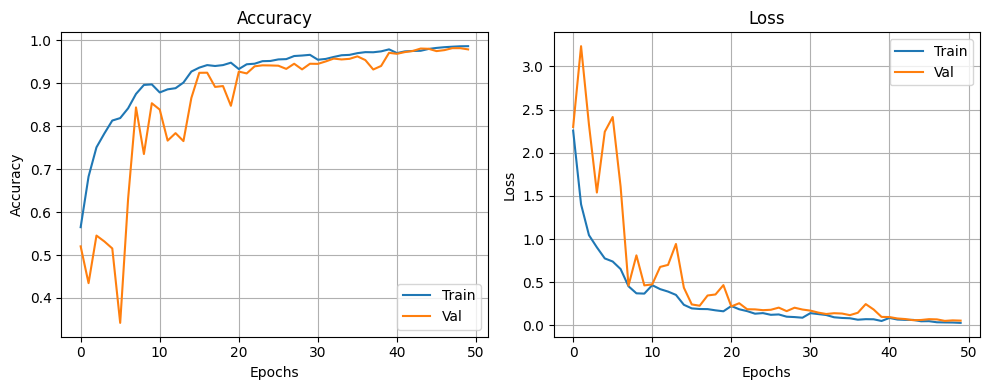

In [ ]:
accs_curve = []
vals_acc = []
losses_curve = []
vals_loss = []

#graphing accuracy and loss curves across train and test

for spot in total_history:
    accs_curve.append(spot.history["accuracy"])
    losses_curve.append(spot.history["loss"])
    vals_acc.append(spot.history["val_accuracy"])
    vals_loss.append(spot.history["val_loss"])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(np.array(accs_curve).flatten(), label = "Train")
axes[0].plot(np.array(vals_acc).flatten(), label = "Val")
axes[0].set_title("Accuracy")
axes[0].legend(loc="lower right")
axes[0].grid()
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")

axes[1].plot(np.array(losses_curve).flatten(), label = "Train")
axes[1].plot(np.array(vals_loss).flatten(), label = "Val")
axes[1].set_title("Loss")
axes[1].legend(loc="upper right")
axes[1].grid()
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")

plt.tight_layout()
plt.show()


Notice an interesting pattern: After every dataset is finished (10 epochs), accuracy drops and loss spikes a little, before restabilising. This shows that each dataset may have some subtle innate differences (eg. weeds from different australian regions)

110/110 ━━━━━━━━━━━━━━━━━━━━ 37s 337ms/step
example of the cnn output showing probabilities:
[4.5713344e-01 5.4048985e-01 6.8130251e-04 5.9850888e-11 5.4113674e-08
 1.5990572e-08 1.0390732e-03 1.2636453e-06 6.5502134e-04]
                precision    recall  f1-score   support

  Chinee_Apple       0.99      0.99      0.99       226
       Lantana       0.96      1.00      0.98       213
      Negative       0.99      1.00      1.00      1822
   Parkinsonia       1.00      1.00      1.00       207
    Parthenium       1.00      1.00      1.00       205
Prickly_Acacia       1.00      1.00      1.00       213
   Rubber_Vine       0.99      0.99      0.99       202
     Siam_Weed       0.98      1.00      0.99       215
    Snake_Weed       0.99      0.87      0.92       204

      accuracy                           0.99      3507
     macro avg       0.99      0.98      0.98      3507
  weighted avg       0.99      0.99      0.99      3507



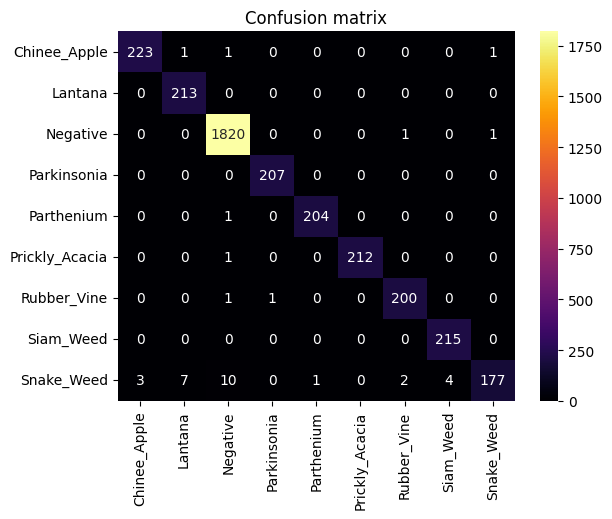

In [ ]:
probabalistics = model.predict(test_gen) #9 probability output

print("example of the cnn output showing probabilities:")
print(probabalistics[0]) #0-1 output for probability values of classes

prediction_ints = np.argmax(probabalistics, axis=1) #converts row into single value of highest prob. index = class ID
true_ints = test_gen.classes

names = [label_map[i] for i in sorted(np.unique(true_ints))] #sorted to ensure names match indexes in classification report

print(classification_report(true_ints, prediction_ints, target_names = names)) #classification report and confusion matrix

cm = confusion_matrix(true_ints, prediction_ints)
sns.heatmap(cm, annot=True, fmt='d', cmap="inferno")
plt.title("Confusion matrix")
plt.xticks(np.arange(9) + 0.5, names, rotation=90)
plt.yticks(np.arange(9) + 0.5, names, rotation=0)
plt.show()

Text(0.5, 1.0, 'Misclassification report')

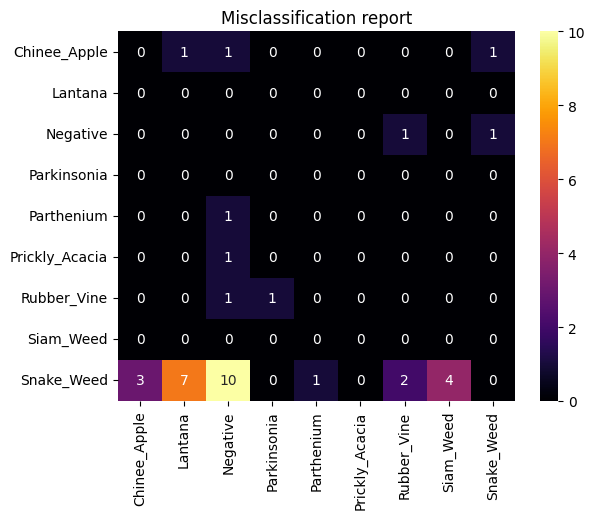

In [ ]:
np.fill_diagonal(cm, 0) #removing all correctly classified examples - in the diagonal
sns.heatmap(cm, annot=True, cmap="inferno")
plt.xticks(np.arange(9) + 0.5, names, rotation=90)
plt.yticks(np.arange(9) + 0.5, names, rotation=0)
plt.title("Misclassification report")

## Advanced Metrics

In [ ]:
print(f"Matthew's Correlation Coefficient : {matthews_corrcoef(true_ints, prediction_ints)}")
print(f"Accuracy : {accuracy_score(true_ints, prediction_ints)}")
print(f"f1 score : {f1_score(true_ints, prediction_ints, average='weighted')}")
print(f"Log loss : {log_loss(true_ints, probabalistics)}")
print(f"Recall : {recall_score(true_ints, prediction_ints, average='weighted')}")
print(f"Precision : {precision_score(true_ints, prediction_ints, average='weighted')}")

Matthew's Correlation Coefficient : 0.9853786598686737
Accuracy : 0.9897348160821214
f1 score : 0.9895004705151638
Log loss : 0.031397308146750874
Recall : 0.9897348160821214
Precision : 0.9897902798924548


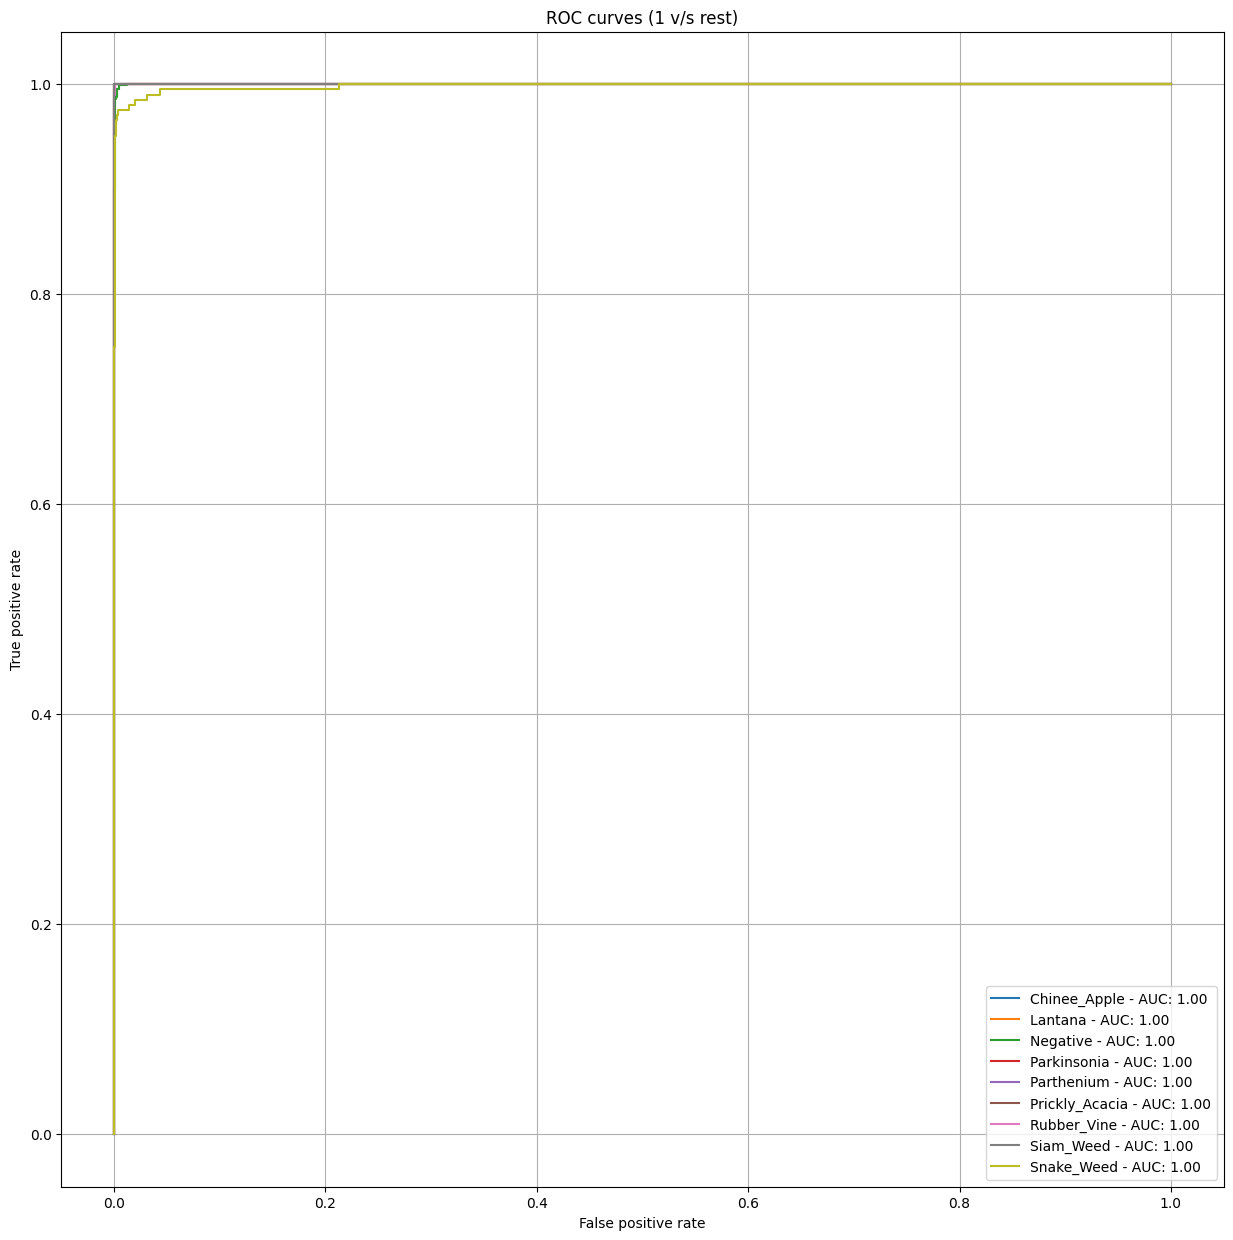

In [ ]:
from sklearn.calibration import label_binarize

real_bin = label_binarize(true_ints, classes=np.arange(10))

plt.figure(figsize=(15, 15))

for i in range(9):
    
    false_p_rate, true_p_rate, thresholds = roc_curve(real_bin[:, i], probabalistics[:, i])
    
    roc_auc = auc(false_p_rate, true_p_rate) #higher area under curve - straighter the lines - lesser the FPR
    
    plt.plot(false_p_rate, true_p_rate, label=f"{names[i]} - AUC: {roc_auc:.2f}")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves (1 v/s rest)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


## Conclusion

With high metrics, the model solves the problem posed by the dataset.